In [2]:
from config import *
import requests
import plotly
import matplotlib.pyplot as plt
import yfinance as yf
import os
import sys
import pandas as pd
from scipy.stats import pearsonr

# Global Vars

In [3]:
BASE_FRED = 'https://api.stlouisfed.org/fred/series/observations'

# Functions

In [4]:
def pullHistoricalPrices(tickers):
    ticker_histories = dict()
    for ticker_i in tickers:
        ticker_histories[ticker_i] = yf.Ticker(ticker_i).history(period="max").reset_index()
    return ticker_histories

In [74]:
def shiftDf(indicators_histories, indicator_1, indicator_2, shift):
    df_a = indicators_histories[indicator_1].set_index('date')
    df_b = indicators_histories[indicator_2].set_index('date')
    df_b = df_b.shift(periods=shift*30)
    df_join = df_a.join(df_b, how='inner', lsuffix='_a', rsuffix='_b')

    df_join = df_join[(df_join.value_b.notnull()) & (df_join.value_b.notnull())]
    
    return df_join

In [75]:
def getOptimalShiftDf(indicators_histories, indicator_1, indicator_2):
    corrs_list = list()

    for i in range(20):
        df_join = shiftDf(indicators_histories, indicator_1, indicator_2, i)

        temp_obj = dict()
        corr, _ = pearsonr(df_join['value_a'], df_join['value_b'])
        temp_obj['shift'] = i
        temp_obj['corr'] = corr

        corrs_list.append(temp_obj)

    df_corrs = pd.DataFrame(corrs_list)

    return df_corrs

# Pull Data

In [5]:
with open('./data/tickers.txt', 'r') as fp:
    tickers = [x.replace('\n', '') for x in fp.readlines()]

In [6]:
ticker_histories = pullHistoricalPrices(tickers)

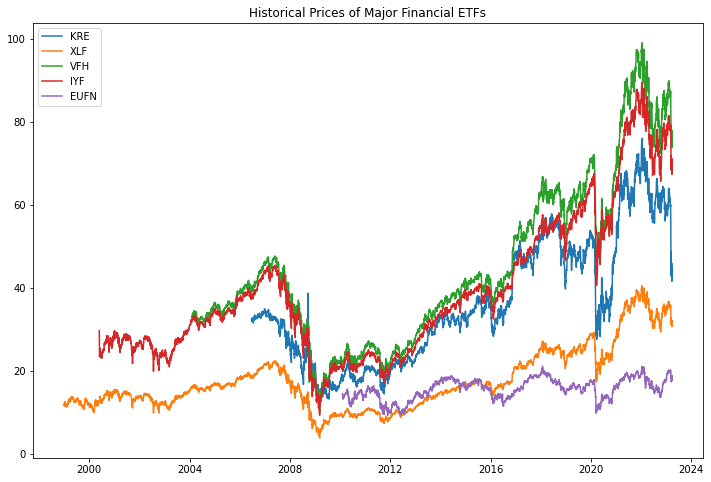

In [7]:
plt.figure(figsize=(12,8))
for ticker_i in ticker_histories:
    df_ticker = ticker_histories[ticker_i]
    plt.plot(df_ticker['Date'], df_ticker['Open'], label=ticker_i)
plt.legend()
plt.title('Historical Prices of Major Financial ETFs')
plt.show()

### Case Study KRE

# Economic Data

In [93]:
series_list = ['CORESTICKM159SFRBATL', 'UNRATE', 'T10Y2Y', 'DPRIME']
# 'FF'

In [94]:
indicators_histories = dict()
for series_i in series_list:
    parameters = {
        'api_key': TOKEN_FRED,
        'series_id': series_i,
        'observation_start': '2000-01-01', # YYYY-MM-DD 
        'file_type': 'json'
    }

    response_json = requests.get(BASE_FRED, parameters).json()
    df_indicator = pd.DataFrame(response_json['observations'])
    df_indicator = df_indicator[df_indicator['value'] != '.']
    df_indicator['date'] = pd.to_datetime(df_indicator['date'])
    df_indicator['value'] = df_indicator['value'].astype('float')
    indicators_histories[series_i] = df_indicator

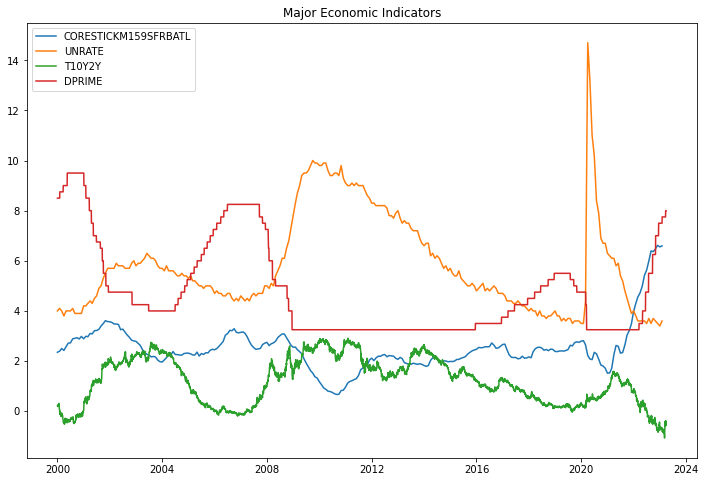

In [95]:
plt.figure(figsize=(12,8))
for indicator_i in indicators_histories:
    df_indicator = indicators_histories[indicator_i]
    plt.plot(df_indicator['date'], df_indicator['value'], label=indicator_i)
plt.legend()
plt.title('Major Economic Indicators')
plt.show()

### Relationship Analysis

#### Inflation & Interest Rates

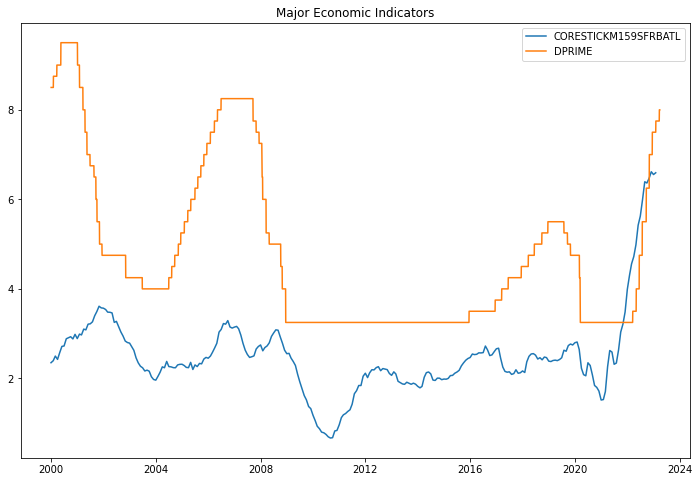

In [96]:
plt.figure(figsize=(12,8))
for indicator_i in ['CORESTICKM159SFRBATL', 'DPRIME']:
    df_indicator = indicators_histories[indicator_i]
    plt.plot(df_indicator['date'], df_indicator['value'], label=indicator_i)
plt.legend()
plt.title('Major Economic Indicators')
plt.show()

Aim to maximize correlation to identify optimal offset and determine lag of interest rates with respect to inflation

In [98]:
df_corrs = getOptimalShiftDf(indicators_histories, 'CORESTICKM159SFRBATL', 'DPRIME')
df_corrs['abs_corr'] = df_corrs['corr'].apply(lambda x: abs(x))

0
0.3831463666341288


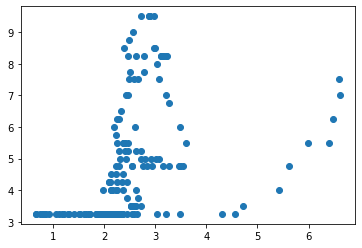

In [99]:
optimal_shift = df_corrs.sort_values('abs_corr', ascending=False).head(1)['shift'].values[0]
df_join = shiftDf(indicators_histories, 'CORESTICKM159SFRBATL', 'DPRIME', optimal_shift).reset_index()

plt.scatter(df_join['value_a'], df_join['value_b'])
corr, _ = pearsonr(df_join['value_a'], df_join['value_b'])
print(optimal_shift)
print(corr)

#### Interest Rates & Inverted YAW

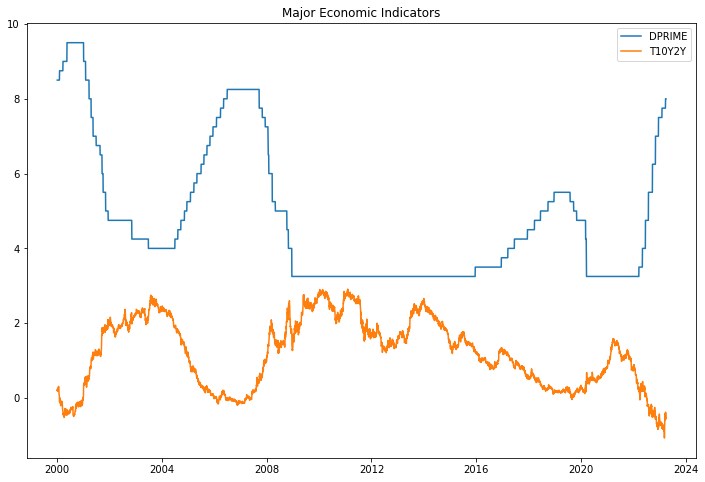

In [100]:
plt.figure(figsize=(12,8))
for indicator_i in ['DPRIME', 'T10Y2Y']:
    df_indicator = indicators_histories[indicator_i]
    plt.plot(df_indicator['date'], df_indicator['value'], label=indicator_i)
plt.legend()
plt.title('Major Economic Indicators')
plt.show()

In [101]:
df_corrs = getOptimalShiftDf(indicators_histories, 'DPRIME', 'T10Y2Y')
df_corrs['abs_corr'] = df_corrs['corr'].apply(lambda x: abs(x))

3
-0.7225723273729852


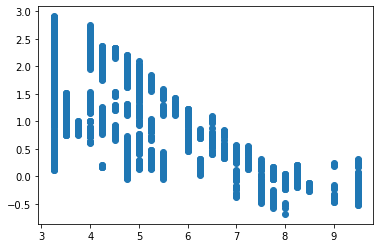

In [102]:
optimal_shift = df_corrs.sort_values('abs_corr', ascending=False).head(1)['shift'].values[0]
df_join = shiftDf(indicators_histories, 'DPRIME', 'T10Y2Y', optimal_shift).reset_index()

plt.scatter(df_join['value_a'], df_join['value_b'])
corr, _ = pearsonr(df_join['value_a'], df_join['value_b'])
print(optimal_shift)
print(corr)

Strong negative correlation between interest rate and yield deficit. Usually 3 month lag for lows in yield spread from interest rate hike

# Archive

In [32]:
# add_on = '/stock/{0}/chart/{1}'.format(ticker_i, '5y')
# parameters = {
#     'token':TOKEN_IEX,
# }
# tickers_json = requests.get(BASE_URL + add_on, parameters)